## Loading the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/BCDUfrom 

[Errno 2] No such file or directory: '/content/drive/MyDrive/BCDUfrom'
/content


In [3]:
!pwd

/content


### Preparing Test-Train split

#### (need not run for this colab notebook as '/processed_data' already contains test-train files)

In [5]:
from __future__ import division
import nibabel as nib
import numpy as np
# import Reza_functions.py as RF
import glob
import os

# Define Train data and mask
Data_train   = []
Mask_train   = []
Maska_train  = []
FOV_train    = []

idx_count =1
Tr_add = '3d_images'

Tr_list = glob.glob(Tr_add+'/*.gz')

for idx in range(len(Tr_list)):
    b = Tr_list[idx]
    a = b[len(Tr_add)+1:len(Tr_add)+4]
    if a=='IMG':
       print(idx_count)
       a = b[len(Tr_add)+5:len(b)]
       add = (Tr_add+'/MASK_' + a)
       vol = nib.load(Tr_list[idx])
       seg = nib.load(add)
       # Get the axials images and corresponding masks
       vol_ims, lung, around_lung, FOV = return_axials(vol, seg)          
       segmentation  = seg.get_data()
       # Insert samples to the Train data, which has the segmentation label
       for idx in range(vol.shape[0]):
           if ~( np.sum(np.sum(np.sum(segmentation[idx, :, :]))) == 0): 
               Data_train.append(vol_ims [idx, :, :])
               Mask_train.append(lung[idx, :, :])
               Maska_train.append(around_lung[idx, :, :])               
               FOV_train.append(FOV[idx, :, :])               
       idx_count += 1
        
Data_train  = np.array(Data_train)
Mask_train  = np.array(Mask_train)
Maska_train = np.array(Maska_train)
FOV_train   = np.array(FOV_train)

# We use 70% of the data for training and 30% for test
alpha = np.int16(np.floor(Data_train.shape[0]* 0.7))
en_d  = Data_train.shape[0]

Train_img      = Data_train[0:alpha,:,:]
Test_img       = Data_train[alpha:en_d,:,:]

Train_mask     = Mask_train[0:alpha,:,:]
Test_mask      = Mask_train[alpha:en_d,:,:]

Train_maska     = Maska_train[0:alpha,:,:]
Test_maska      = Maska_train[alpha:en_d,:,:]

FOV_tr     = FOV_train[0:alpha,:,:]
FOV_te      = FOV_train[alpha:en_d,:,:]

folder = './processed_data/'
if not os.path.exists(folder):
    os.makedirs(folder)
    
np.save(folder+'data_train' , Train_img)
np.save(folder+'data_test'  , Test_img)
np.save(folder+'mask_train' , Train_mask)
np.save(folder+'mask_test'  , Test_mask)

np.save(folder+'Train_maska' , Train_maska)
np.save(folder+'Test_maska'  , Test_maska)
np.save(folder+'FOV_tr'      , FOV_tr)
np.save(folder+'FOV_te'      , FOV_te)

IndexError: ignored

## Compiling Models

### Bi-directional Convolutional U-Net with Dense connections

In [10]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *
import numpy as np
    

# model with dense connections
def BCDU_net_D3(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])    
    return model

# model without dense connections
def BCDU_net_D1(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
   
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv4_1)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])    
    return model

## Training the model

In [ ]:
# -*- coding: utf-8 -*-
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks
import pickle
   
####################################  Load Data #####################################
folder = './processed_data/'
tr_data    = np.load(folder+'data_train.npy')
tr_mask    = np.load(folder+'Train_maska.npy')
tr_data    = np.expand_dims(tr_data, axis=3)
tr_mask    = np.expand_dims(tr_mask, axis=3)

print('Dataset loaded')

tr_data   = tr_data /255.

print('dataset Normalized')

# Build model
model = BCDU_net_D1(input_size = (512,512,1))
# model = BCDU_net_D3(input_size = (512,512,1))
model.summary()

print('Training')
batch_size = 1
nb_epoch   = 15

mcp_save = ModelCheckpoint('weight_lung_D1', save_best_only=True, monitor='val_loss', mode='min')
# mcp_save = ModelCheckpoint('weight_lung_D3', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
history = model.fit(tr_data,tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_split=0.2, callbacks=[mcp_save, reduce_lr_loss] )
  
print('Trained model saved')
with open('hist_lung', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Dataset loaded
dataset Normalized
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                           

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training
Epoch 1/15
571/571 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.9677

571/571 [==============================] - 401s 667ms/step - loss: 0.4691 - accuracy: 0.9677 - val_loss: 0.4275 - val_accuracy: 0.9793 - lr: 1.0000e-04
Epoch 2/15
571/571 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.9811

571/571 [==============================] - 359s 629ms/step - loss: 0.4410 - accuracy: 0.9811 - val_loss: 0.3954 - val_accuracy: 0.9921 - lr: 1.0000e-04
Epoch 3/15
571/571 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.9878

571/571 [==============================] - 361s 632ms/step - loss: 0.4184 - accuracy: 0.9878 - val_loss: 0.3793 - val_accuracy: 0.9934 - lr: 1.0000e-04
Epoch 4/15
571/571 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.9896

571/571 [==============================] - 375s 656ms/step - loss: 0.4005 - accuracy: 0.9896 - val_loss: 0.3686 - val_accuracy: 0.9904 - lr: 1.0000e-04
Epoch 5/15
571/571 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.9898

571/571 [==============================] - 374s 655ms/step - loss: 0.3840 - accuracy: 0.9898 - val_loss: 0.3494 - val_accuracy: 0.9941 - lr: 1.0000e-04
Epoch 6/15
571/571 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.9910

571/571 [==============================] - 374s 655ms/step - loss: 0.3675 - accuracy: 0.9910 - val_loss: 0.3361 - val_accuracy: 0.9939 - lr: 1.0000e-04
Epoch 7/15
571/571 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.9918

571/571 [==============================] - 375s 656ms/step - loss: 0.3516 - accuracy: 0.9918 - val_loss: 0.3228 - val_accuracy: 0.9941 - lr: 1.0000e-04
Epoch 8/15
571/571 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.9922

571/571 [==============================] - 360s 630ms/step - loss: 0.3372 - accuracy: 0.9922 - val_loss: 0.3120 - val_accuracy: 0.9919 - lr: 1.0000e-04
Epoch 9/15
571/571 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.9927

571/571 [==============================] - 358s 627ms/step - loss: 0.3229 - accuracy: 0.9927 - val_loss: 0.2955 - val_accuracy: 0.9949 - lr: 1.0000e-04
Epoch 10/15
571/571 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.9929

571/571 [==============================] - 374s 655ms/step - loss: 0.3099 - accuracy: 0.9929 - val_loss: 0.2860 - val_accuracy: 0.9934 - lr: 1.0000e-04
Epoch 11/15
571/571 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9932

571/571 [==============================] - 374s 656ms/step - loss: 0.2971 - accuracy: 0.9932 - val_loss: 0.2731 - val_accuracy: 0.9944 - lr: 1.0000e-04
Epoch 12/15
571/571 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.9937

571/571 [==============================] - 374s 656ms/step - loss: 0.2843 - accuracy: 0.9937 - val_loss: 0.2642 - val_accuracy: 0.9935 - lr: 1.0000e-04
Epoch 13/15
571/571 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9940

571/571 [==============================] - 372s 652ms/step - loss: 0.2723 - accuracy: 0.9940 - val_loss: 0.2509 - val_accuracy: 0.9946 - lr: 1.0000e-04
Epoch 14/15
571/571 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9941

571/571 [==============================] - 358s 627ms/step - loss: 0.2613 - accuracy: 0.9941 - val_loss: 0.2403 - val_accuracy: 0.9954 - lr: 1.0000e-04
Epoch 15/15
571/571 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9945

571/571 [==============================] - 358s 626ms/step - loss: 0.2500 - accuracy: 0.9945 - val_loss: 0.2308 - val_accuracy: 0.9949 - lr: 1.0000e-04
Trained model saved


## Evaluating Model performances

<ipython-input-5-8cd155a97d99>:13: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion


Dataset loaded
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_20[0][0]']              
                                )                                            

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


154/154 [==============================] - 2819s 18s/step
(80478208, 1)

Area under the ROC curve: 0.9944804640128951

Area under Precision-Recall curve: 0.9844339821987166

Confusion matrix:  Custom threshold (for positive) of 0.5
[[69894299   259966]
 [   75710 10248233]]
Global Accuracy: 0.9958289826731729
Specificity: 0.9962943664223408
Sensitivity: 0.9926665616034493
Precision: 0.9752606512305296

F1 score (F-measure): 0.9838866305730827


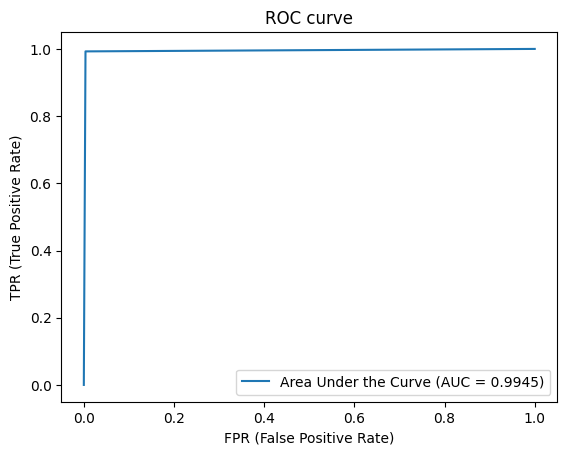

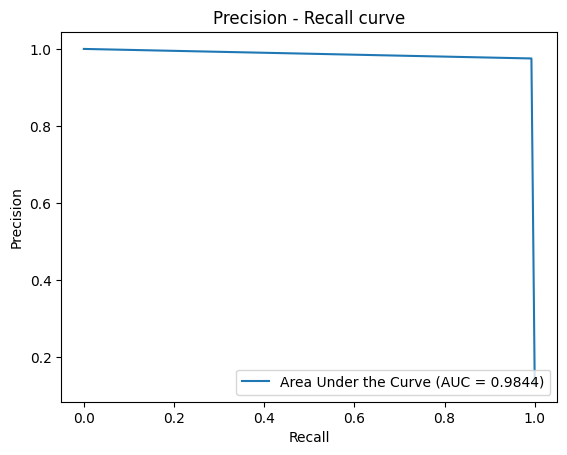

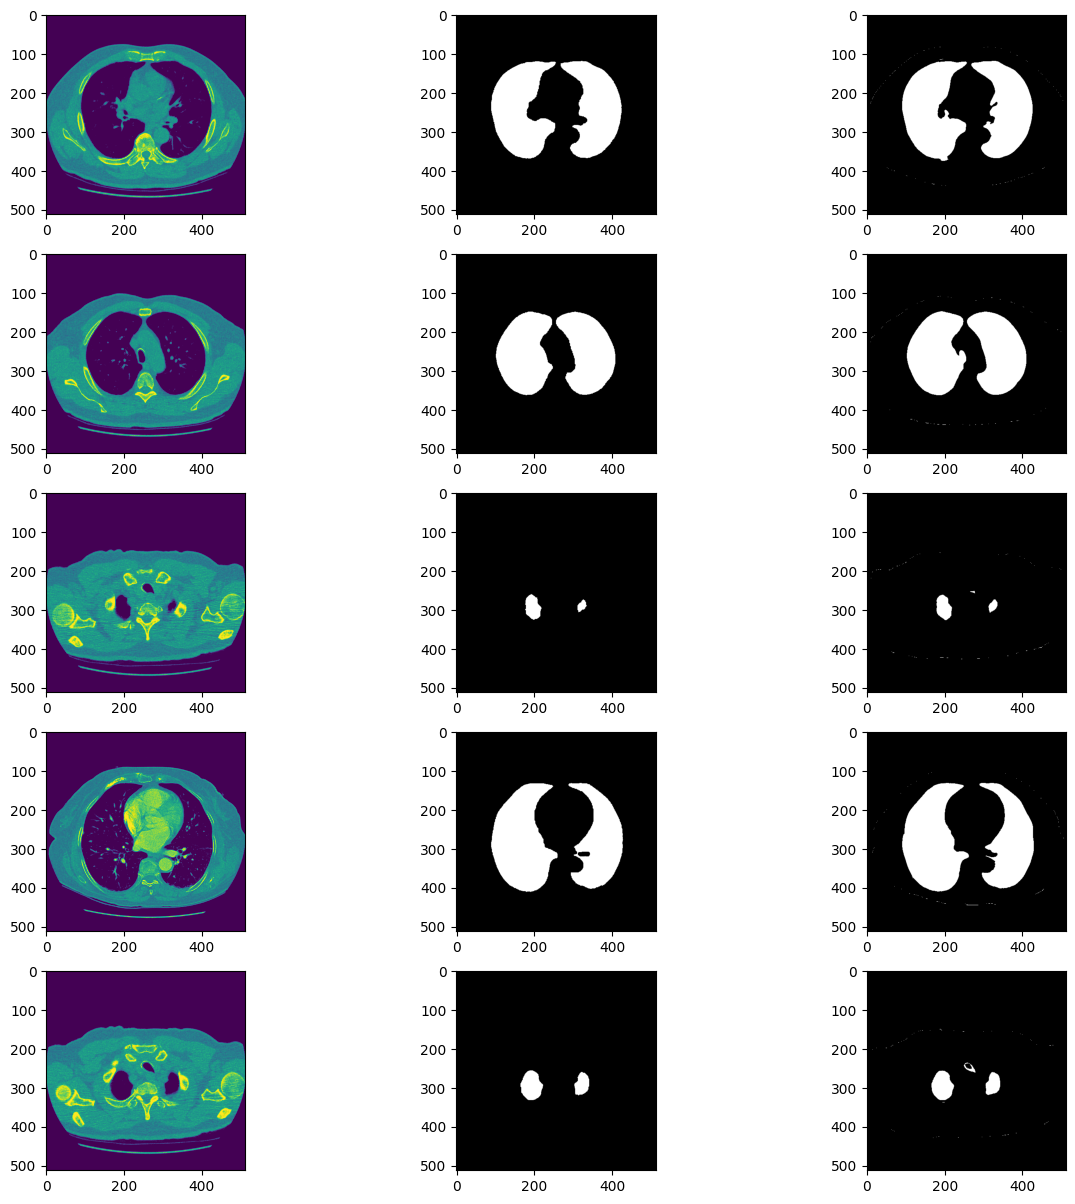

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion

####################################  Load Data #####################################
folder    = './processed_data/'
te_data   = np.load(folder+'data_test.npy')
FOV       = np.load(folder+'FOV_te.npy')
te_mask   = np.load(folder+'mask_test.npy')

te_data  = np.expand_dims(te_data, axis=3)

print('Dataset loaded')
te_data2 = te_data /255.
model = BCDU_net_D1(input_size = (512,512,1))
# model = BCDU_net_D3(input_size = (512,512,1))
model.summary()
model.load_weights('weight_lung_D1')
# model.load_weights('weight_lung_D3')
predictions = model.predict(te_data2, batch_size=2, verbose=1)

# Post-processing
predictions = np.squeeze(predictions)
predictions = np.where(predictions>0.5, 1, 0)
Estimated_lung = np.where((FOV - predictions)>0.5, 1, 0)

# Performance checking

y_scores = Estimated_lung.reshape(Estimated_lung.shape[0]*Estimated_lung.shape[1]*Estimated_lung.shape[2], 1)
print(y_scores.shape)

y_true = te_mask.reshape(te_mask.shape[0]*te_mask.shape[1]*te_mask.shape[2], 1)

y_scores = np.where(y_scores>0.5, 1, 0)
y_true   = np.where(y_true>0.5, 1, 0)

output_folder = 'output/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(output_folder+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0] 
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(output_folder+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(output_folder+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                # + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

# Sample results
fig,ax = plt.subplots(5, 3, figsize=[15,15])
all_ind = [1, 100, 200, 253, 193] # random samples
all_ind = np.array(all_ind)
for idx in range(5):
    ax[idx, 0].imshow(np.uint8(np.squeeze(te_data[all_ind[idx]])))
    ax[idx, 1].imshow(np.squeeze(te_mask[all_ind[idx]]), cmap='gray')  
    ax[idx, 2].imshow(np.squeeze(Estimated_lung[all_ind[idx]]), cmap='gray')  
        
plt.savefig('sample_results.png')
